### Probabilistic Sharpe Ratio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, norm
from FinancialMachineLearning.backtest.backtest_statistics import *

np.random.seed(42)

#### Strategy 1

simulate a distribution of returns with negative skewness

In [2]:
mean_ret = 0.01
std_ret = 0.01
skew_ret = -.99
alpha = skew_to_alpha(skew_ret)
dist_st1 = skewnorm(loc = mean_ret, scale = std_ret, a = alpha)

In [3]:
true_mean_st1 = dist_st1.stats('m')
true_std_st1  = np.sqrt(dist_st1.stats('v'))
true_skew_st1  = dist_st1.stats('s')
true_kurt_st1  = dist_st1.stats('k') + 3
print('Long term true weekly mean returns st1: {:.4f}'.format(true_mean_st1))
print('Long term true std returns st1: {:.4f}'.format(true_std_st1))
print('Long term true skew returns st1: {:.4f}'.format(true_skew_st1))
print('Long term true kurt returns st1: {:.4f}'.format(true_kurt_st1))

Long term true weekly mean returns st1: 0.0020
Long term true std returns st1: 0.0060
Long term true skew returns st1: -0.9900
Long term true kurt returns st1: 3.8630


Generates random **weekly returns** and check their moments statistic (in a large sample the skew should be equal to `skew_returns`, **the other moments are not guaranteed to acommplish our initial conditions**)

In [4]:
size = 52 # weekly

seed_st1 = 42
ret_st1 = dist_st1.rvs(size = size, random_state = seed_st1)
moments_st1 = moments(ret_st1)
print(moments_st1)

mean    0.002450
std     0.005661
skew   -0.703969
kurt    2.244061
dtype: float64


Calculate their estimated Sharpe Ratio($\hat{\mathrm{SR}}$). It is 'estimated' because it use the historical returns as a prediction of the future returns.

In [5]:
sr_st1 = estimated_sharpe_ratio(ret_st1)
print(f"Sharpe Ratio of strategy 1 dist. : {sr_st1 : .4f}")

Sharpe Ratio of strategy 1 dist. :  0.4328


In [6]:
ann_sr_st1 = ann_estimated_sharpe_ratio(ret_st1, periods = 52)
print(f"Annual Sharpe Ratio of strategy 1 dist. : {ann_sr_st1 : .4f}")

Annual Sharpe Ratio of strategy 1 dist. :  3.1211


#### Strategy 2

Simulate a normal distribution od returns with better mean and same std as the strategy 1

In [7]:
extra_edge = 0.0012
dist_st2 = norm(loc = true_mean_st1 + extra_edge, scale = true_std_st1)

In [8]:
true_mean_st2 = dist_st2.stats('m')
true_std_st2  = np.sqrt(dist_st2.stats('v'))
true_skew_st2  = dist_st2.stats('s')
true_kurt_st2  = dist_st2.stats('k') + 3
print('Long term true weekly mean returns st2: {:.4f}'.format(true_mean_st2))
print('Long term true std returns st2: {:.4f}'.format(true_std_st2))
print('Long term true skew returns st2: {:.2f}'.format(true_skew_st2))
print('Long term true kurt returns st2: {:.2f}'.format(true_kurt_st2))

Long term true weekly mean returns st2: 0.0032
Long term true std returns st2: 0.0060
Long term true skew returns st2: 0.00
Long term true kurt returns st2: 3.00


Generates random **weekly returns** and check their moments statistic (in a large sample the mean and std should be equal to the `moments_st1`, and the skew should be 0 and kurtosis 3)

In [9]:
seed_st2 = 42
ret_st2 = dist_st2.rvs(size = size, random_state = seed_st2)

moments_st2 = moments(ret_st2)
print(moments_st2)

mean    0.001911
std     0.005544
skew    0.116464
kurt    2.607143
dtype: float64


In [10]:
sr_st2 = estimated_sharpe_ratio(ret_st2)
print(f"Sharpe Ratio of strategy 2 dist. : {sr_st2 : .4f}")

Sharpe Ratio of strategy 2 dist. :  0.3447


In [11]:
ann_sr_st2 = ann_estimated_sharpe_ratio(ret_st2)
print(f"Annual Sharpe Ratio of strategy 2 dist. : {ann_sr_st2 : .4f}")

Annual Sharpe Ratio of strategy 2 dist. :  5.5683


#### Probabilistic Sharpe Ratio (PSR)

```
def probabalistic_sharpe_ratio(
    observed_sr: float, 
    benchmark_sr: float,
    number_of_returns: int, 
    skewness_of_returns: float = 0,
    kurtosis_of_returns: float = 3
) -> float
```

In [12]:
sharpe_bench = 0

In [13]:
psr_st1 = probabilistic_sharpe_ratio(
    observed_sr = sr_st1,
    benchmark_sr = sharpe_bench,
    number_of_returns = len(ret_st1),
    skewness_of_returns = true_skew_st1,
    kurtosis_of_returns = true_kurt_st1
)
print(f"Probabilistic Sharpe Ratio of strategy 1 : {psr_st1 : .4f}")

Probabilistic Sharpe Ratio of strategy 1 :  0.9933


In [14]:
psr_st2 = probabilistic_sharpe_ratio(
    observed_sr = sr_st2,
    benchmark_sr = sharpe_bench,
    number_of_returns = len(ret_st2),
    skewness_of_returns = true_skew_st2,
    kurtosis_of_returns = true_kurt_st2
)
print(f"Probabilistic Sharpe Ratio of strategy 2 : {psr_st2 : .4f}")

Probabilistic Sharpe Ratio of strategy 2 :  0.9916


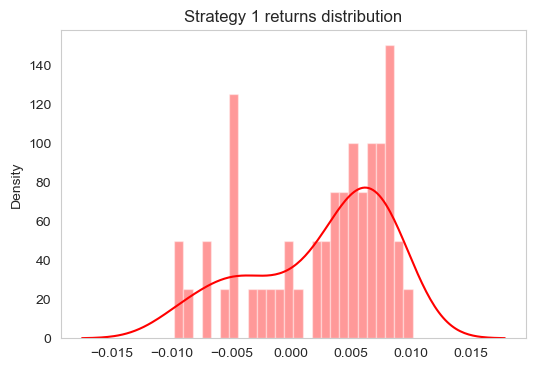

In [15]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (6, 4))
sns.distplot(
    pd.Series(ret_st1), 
    hist = True, 
    kde = True, 
    color = 'red',
    bins = size // 2
).set_title('Strategy 1 returns distribution')
plt.grid(False)
plt.show()

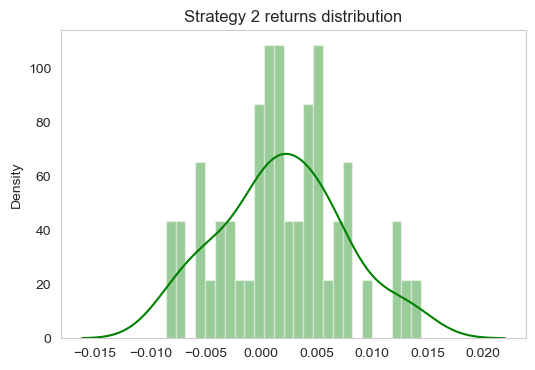

In [16]:
plt.figure(figsize = (6, 4))
sns.distplot(
    pd.Series(ret_st2), 
    hist = True, 
    kde = True, 
    color = 'green',
    bins = size // 2
).set_title('Strategy 2 returns distribution')
plt.grid(False)
plt.show()

In [17]:
estimated_sr_std_st1 = estimated_sharpe_ratio_stdev(ret_st1)
estimated_sr_std_st2 = estimated_sharpe_ratio_stdev(ret_st2)

print(f'The estimated Sharpe Ratio of strategy 1 have a stdDev of: {estimated_sr_std_st1 : .4f}')
print(f'The estimated Sharpe Ratio of strategy 2 have a stdDev of: {estimated_sr_std_st2 : .4f}')

The estimated Sharpe Ratio of strategy 1 have a stdDev of:  0.1635
The estimated Sharpe Ratio of strategy 2 have a stdDev of:  0.1406


#### Out of sample

In [18]:
oos_size = 10000000

oos_ret_st1 = dist_st1.rvs(size = oos_size)
true_moments_st1 = moments(oos_ret_st1)
print(true_moments_st1)

mean    0.002025
std     0.006034
skew   -0.989112
kurt    3.860608
dtype: float64


In [19]:
ann_true_sr_st1 = ann_estimated_sharpe_ratio(oos_ret_st1, periods = 52)
print(f"Annual true sharpe ratio of strategy 1 : {ann_true_sr_st1 : .3f}")

Annual true sharpe ratio of strategy 1 :  2.421


In [20]:
oos_ret_st2 = dist_st2.rvs(size = oos_size)
true_moments_st2 = moments(oos_ret_st2)
print(true_moments_st2)

mean    0.003225
std     0.006038
skew    0.000797
kurt    2.999979
dtype: float64


In [21]:
ann_true_sr_st2 = ann_estimated_sharpe_ratio(oos_ret_st2, periods = 52)
print(f"Annual true sharpe ratio of strategy 2 : {ann_true_sr_st2 : .3f}")

Annual true sharpe ratio of strategy 2 :  3.851


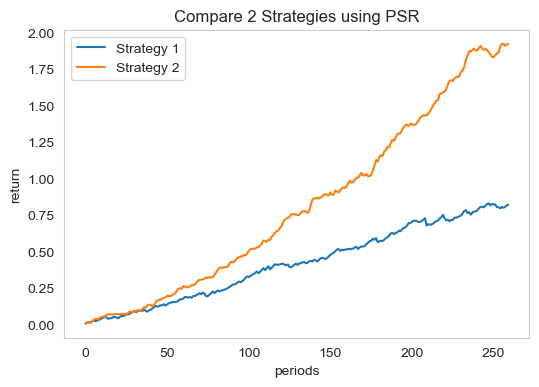

In [22]:
pd.DataFrame(
    {'Strategy 1': pd.Series(oos_ret_st1).add(1).cumprod().sub(1).iloc[:52*5],
     'Strategy 2': pd.Series(oos_ret_st2).add(1).cumprod().sub(1).iloc[:52*5]}
).plot(
    figsize = (6, 4),
    grid = False,
    title = "Compare 2 Strategies using PSR"
)
plt.xlabel("periods")
plt.ylabel("return")
plt.show()

<Axes: title={'center': 'Distribution of 2 strategies'}, ylabel='Density'>

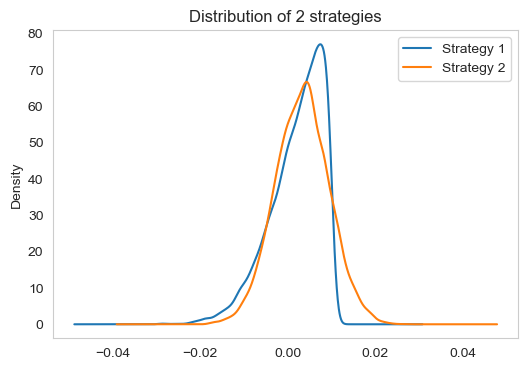

In [23]:
pd.DataFrame(
    {'Strategy 1': pd.Series(oos_ret_st1).iloc[:10000],
     'Strategy 2': pd.Series(oos_ret_st2).iloc[:10000]}
).plot.density(
    grid = False,
    figsize = (6,4),
    title = "Distribution of 2 strategies"
)